In [1]:
import numpy as np
import matplotlib.pyplot as plt
# from pyLOESS import LOESS

# 1. 边界问题 测试

In [4]:
x = np.arange(100, 200, 1)
y = 3 * np.sin(x/10) + np.random.random(x.size)

x1 = np.arange(90, 210, 1)

k = 15
model = LOESS(k, istimeseries=True)
model.fit(x, y)
pred = model.predict(x1)

fig = plt.figure(figsize=(10, 6))
plt.plot(x1, pred)
plt.scatter(x, y, s=20)

NameError: name 'LOESS' is not defined

# 2. 不同 ${K}$ 对结果的影响

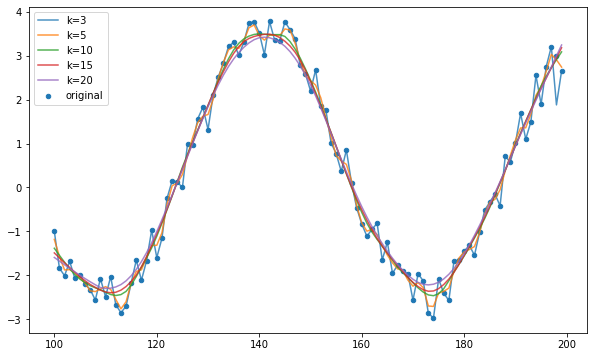

In [3]:
x = np.arange(100, 200, 1)
y = 3 * np.sin(x/10) + np.random.random(x.size)

x1 = np.arange(100, 200, 1)


fig = plt.figure(figsize=(10, 6))
plt.scatter(x, y, s=20, label='original')
for k in [3, 5, 10, 15, 20]:
    model = LOESS(k, istimeseries=True)
    model.fit(x, y)
    pred = model.predict(x)
    plt.plot(x1, pred, alpha=0.8, label='k={0}'.format(k))
plt.legend()

# 3. istimeseries 参数 对比

In [3]:
x = np.arange(100, 200, 1)
y = 3 * np.sin(x/10) + np.random.random(x.size)

x1 = np.arange(90, 210, 1)

k = 10
model = LOESS(k, istimeseries=True)
model.fit(x, y)
pred1 = model.predict(x1)

model = LOESS(k, kernel='bisquare', distance='manhattan', p='1', istimeseries=False)
model.fit(x.reshape(-1, 1), y)
pred2 = model.predict(x1.reshape(-1, 1))


fig = plt.figure(figsize=(20, 6))
ax1 = fig.add_subplot(121)
plt.scatter(x, y, s=20, label='original')
plt.plot(x1, pred1, label='istimeseries=True')
plt.plot(x1, pred2, label='istimeseries=False')
plt.legend()

ax2 = fig.add_subplot(122)
plt.plot(pred1-pred2)
plt.title('Difference')

NameError: name 'LOESS' is not defined

# 4. 非等间距时间序列
对于非等间距，且乱序的散点，使用`istimeseries=Fals` 方法

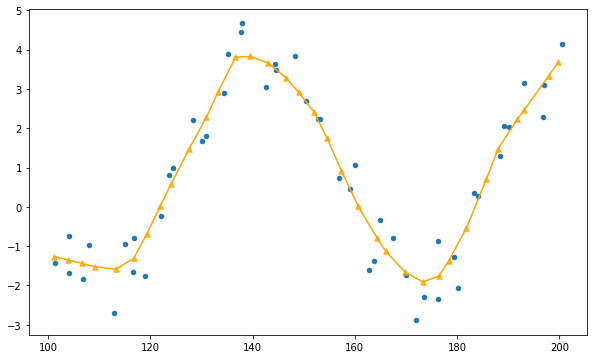

In [5]:
x = np.arange(100, 200, 2)
x = x + np.random.random(x.size) * 3
np.random.shuffle(x)
y = 3 * np.sin(x/10) + np.random.random(x.size)*2

x0 = np.arange(100, 200, 3)
x0 = x0 + np.random.random(x0.size) * 2
np.random.shuffle(x0)


model = LOESS(k, kernel='bisquare', distance='manhattan', p='1', istimeseries=False)
model.fit(x.reshape(-1, 1), y)
pred = model.predict(x0.reshape(-1, 1))

fig = plt.figure(figsize=(10, 6))
plt.scatter(x, y, s=20)
plt.scatter(x0, pred, marker='^', alpha=0.8, s=30, color='orange')

index = np.argsort(x0)
plt.plot(x0[index], pred[index], color='orange')

LinAlgError: Singular matrix

In [23]:
'''

'''

import numpy as np

from sklearn.neighbors import NearestNeighbors
from sklearn.base import BaseEstimator, RegressorMixin

from sklearn.preprocessing import PolynomialFeatures

from sklearn.exceptions import DataDimensionalityWarning













class LOESSTimeseries(BaseEstimator, RegressorMixin):
    '''
    类 sklearn 的 LOESS 回归
    用于时间序列的
    '''
    def __init__(self, k=5, kernel='bisquare',  degree=1, robust=True):

        self.k = k #
        self.kernel = kernel

        self.degree = degree
        self.robust = robust

        # front_length 和 behind_length 表示当前值前邻近点数量和后邻近点数量
        self.front_length  = int((self.k-1)/2)
        self.behind_length = self.k - self.front_length
        # k 与 front_length, behind_length 之间的关系
        # 当 k 为奇数时，front_length = behind_length
        # 当 k 为偶数时，front_length = behind_length - 1

        # 索引分界点
        #                    0 <= index < front_length 
        #         front_length <= index < x.size-behind_length
        # x.size-behind_length <= index < x.size
        # 等间距的时间序列数据
        
        # 其他的一些用于判断避对输入判断避免出错的参数
        self.istrained = False
        return None
    # --------------------------------------------
    
    def __kernelFunction(self, x, name):
        '''
        kernel 函数
        '''
        if name == 'bisquare':
            y = np.clip(x, -1, 1)
            y = (1 - y ** 2) ** 2
        
        elif name == 'tricube':
            y = np.clip(x, -1, 1)
            y = (1 - np.abs(y) ** 3) ** 3
        
        elif name == 'epanechnikov':
            y = np.clip(x, -1, 1)
            y = 0.75 * (1 - np.abs(y) ** 2)
        
        return y
    # -------------------------------------------- 
    
    def __x_expand(self, x):
        '''
        增加维度
        '''
        # sklearn.preprocessing.PolynomialFeatures 对象
        if self.degree == 0:
            out = np.ones(x.shape[0], dtype=float)
        
        elif self.degree == 1:
            out = np.ones((x.shape[0], 2), dtype=float)
            out[:, 1] = x
        
        elif self.degree >= 2:
            out = np.ones((x.shape[0], self.degree+1), dtype=float)
            for i in range(1, 1+self.degree):
                out[:, i] = x ** i
        return out
    # -------------------------------------------- 
#     def __findNeighbor_timeseries(self, x, y):
#         '''
#         用于时间序列的查找邻近样本
#         '''
#         all_near_indices = []
        
#         # 前边界索引
#         x_near_indices = [i for i in range(self.k)]
#         for t in range(self.front_length):
#             all_near_indices.append(x_near_indices)
            
#         # 中间 无边界
#         for t in range(self.front_length, x.size - self.behind_length):
#             x_near_indices = [t - self.front_length + i for i in range(self.k)]
#             all_near_indices.append(x_near_indices)
        
#         # 后边界索引
#         x_near_indices = [i for i in range(x.size-self.k, x.size)]
#         for t in range(x.size - self.behind_length, x.size):
#             all_near_indices.append(x_near_indices)
        
#         return all_near_indices
# #         return np.array(np.hstack([x.reshape(-1,1), all_near_indices]))
#     # --------------------------------------------   

    def __findNeigh_index_single(self, x0):
        '''
        用于时间序列x0的查找邻近样本
        '''
        # 下（左）边界点
        if x0 < self.bound_up:
            # self.x_0_flag 用于判断是否为边界点，方便后文是否使用加权回归估计
            x0_flag = 0 
            x0_neigh_indices = [i for i in range(self.k)]
        # 非边界点
        elif x0 < self.bound_low:
            x0_flag = 1
            x0_index = list(self.train_x).index(x0)
            x0_neigh_indices = [x0_index - self.front_length + i for i in range(self.k)]
        # 上（右）边界点
        else:
            x0_flag = 2
            x0_neigh_indices = [i for i in range(self.train_length - self.k, self.train_length)]
        
        return x0_neigh_indices, x0_flag
    # --------------------------------------------   

    def fit(self, x, y):
        '''
        用于判断分界点
        '''
        
        self.train_length = x.size
        
        # 索引分界点
        #                    0 <= index < front_length 
        #         front_length <= index < x.size-behind_length
        # x.size-behind_length <= index < x.size
        self.bound_up  = x[self.front_length]            # < self.bound_up   表示上边界点
        self.bound_low = x[x.size - self.behind_length]  # >= self.bound_low 表示下边界点
        
        self.train_x = x
        self.train_x_expand = self.__x_expand(x)
        self.train_y = y
        
        # 完成训练
        self.istrained = True
        return self
    # --------------------------------------------
    
    def __predict_single(self, x0, x0_expand, x0_neigh, y0_neigh, weight, x0_flag):
        '''
        用搜索的方法查找邻近点，不方便判断边界点，全部用加权最小二乘法评估
        '''
        if x0_flag == 1:
            y0 = np.dot(weight, y0_neigh)/np.sum(weight)
        else:
            matrix_W = np.diag(weight)
            matirx_X = x0_neigh
            try:
                inv = np.linalg.inv(np.dot(np.dot(matirx_X.T, matrix_W), matirx_X))
            except:
                print('对边界点{0}估计时，矩阵 X.T*W*X 不可逆'.format(x0))
                return None

            # 预测
            y0 = np.dot(np.dot(np.dot(np.dot(x0_expand.T, inv), matirx_X.T), matrix_W), y0_neigh)
        return y0
    # --------------------------------------------
    
    def __get_robust_weight(self):
        '''
        # 获取训练样本每个点的robust weight
        # 本身是一个对训练样本预测的过程
        
        '''
        
        train_y_pred = []
        
        for i in range(self.train_x.shape[0]):
            # 目标点
            x0, x0_expand, = self.train_x[i], self.train_x_expand[i]
            # 邻近索引
            x0_neigh_indices, x0_flag = self.__findNeigh_index_single(x0)
            # 邻近点
            x0_neigh = self.train_x_expand[x0_neigh_indices]
            y0_neigh = self.train_y[x0_neigh_indices]
            # 距离
            x0_neigh_dist = np.abs(x0 - self.train_x[x0_neigh_indices])
            # 核权重
            kernel_weight = self.__kernelFunction(x0_neigh_dist / np.max(x0_neigh_dist), name='bisquare') 
            # 预测
            y0 = self.__predict_single(x0, x0_expand, x0_neigh, y0_neigh, kernel_weight, x0_flag)
            # 
            train_y_pred.append(y0)
        # 残差
        resid = np.array(train_y_pred) - self.train_y
        # 鲁棒权重
        return self.__kernelFunction(resid / (6*np.median(np.abs(resid))), name='bisquare')
    # --------------------------------------------
    
    def predict(self, x):
        '''
        预测
        '''
        try:
            assert self.istrained
        except:
            print('模型尚未训练！')
            return None
        
        # 计算鲁棒权重
        if self.robust:
            robust_weight = self.__get_robust_weight()
        
        pred_x_expand = self.__x_expand(x)
        
        n_pred = x.shape[0]
        pred = []
        for i in range(n_pred):
            # 目标点
            x0, x0_expand = x[i], pred_x_expand[i]
            # 邻近点索引
            x0_neigh_indices, x0_flag = self.__findNeigh_index_single(x0)
            # 邻近点
            x0_neigh = self.train_x_expand[x0_neigh_indices]
            y0_neigh = self.train_y[x0_neigh_indices]
             # 邻近点距离
            x0_neigh_dist = np.abs(x0 - self.train_x[x0_neigh_indices])
            # 核权重
            kernel_weight = self.__kernelFunction(x0_neigh_dist / np.max(x0_neigh_dist), name='bisquare') 
            # 总权重
            if self.robust:
                # 鲁棒权重
                x0_neigh_robust_weight =  robust_weight[x0_neigh_indices]
                weight = x0_neigh_robust_weight * kernel_weight
            else:
                weight = kernel_weight
            # 预测
            y0 = self.__predict_single(x0, x0_expand, x0_neigh, y0_neigh, weight, x0_flag)
            # 
            pred.append(y0)
        
        return np.array(pred)
    # --------------------------------------------  
# ================================================================================================





#
#
#  通用的LOESS
#  可用与非时间序列，以及多维输入等
#
#
class LOESSGernealization(BaseEstimator, RegressorMixin):
    '''
    类 sklearn 的 LOESS 回归
    通用的
    '''
    def __init__(self, k=5, kernel='bisquare', distance='manhattan', p='1', degree=1, robust=True, interaction_only=False, include_bias=True):
        '''
        
        '''
        self.k = k #
        self.kernel = kernel

        self.distance = distance
        self.p = p

        self.degree = degree
        self.robust = robust
        
        # 当 degree >= 2 时:
        if degree >= 2:
            self.poly = PolynomialFeatures(degree, interaction_only=False, include_bias=True)
            
        self.istrained = False
        return None
    # --------------------------------------------
    
    def __kernelFunction(self, x, name):
        '''
        kernel 函数
        '''
        if name == 'bisquare':
            y = np.clip(x, -1, 1)
            y = (1 - y ** 2) ** 2
        
        elif name == 'tricube':
            y = np.clip(x, -1, 1)
            y = (1 - np.abs(y) ** 3) ** 3
        
        elif name == 'epanechnikov':
            y = np.clip(x, -1, 1)
            y = 0.75 * (1 - np.abs(y) ** 2)
        
        return y
    # -------------------------------------------- 
    
    def __X_expand(self, X):
        '''
        增加维度
        '''
        # sklearn.preprocessing.PolynomialFeatures 对象
        if self.degree == 0:
            out = np.ones(X.shape[0], dtype=float)
        
        elif self.degree == 1:
            out = np.ones((X.shape[0], X.shape[1]+1), dtype=float)
            out[:, 1:] = X

        elif self.degree >= 2:
            out = self.poly.transform(X)

        return out
    # -------------------------------------------- 
    
    def fit(self, X, y):
        '''
        用搜索的方法查找邻近点，不方便判断边界点，全部用加权最小二乘法评估
        '''
        try:
            assert X.ndim == 2
            assert y.ndim == 1
        except DataDimensionalityWarning:
            print('确保输入数据为2维,输出数据维1维!')
            return None
        
        # sklearn.neighbors.NearestNeighbors类
        self.neighbor = NearestNeighbors(
            n_neighbors = self.k, 
            metric      = self.distance, 
            p           = self.p
        )
        self.neighbor.fit(X, y)
        
        # 
        if self.degree >= 2:
            self.poly.fit(X)
    
        self.train_X = X
        self.train_X_expand = self.__X_expand(X)
        self.train_y = y
        
        # 完成训练
        self.istrained = True
        
        return self
    # --------------------------------------------
    
    def __predict_single(self, x0, x0_neigh, y0_neigh, weight):
        '''
        用搜索的方法查找邻近点，不方便判断边界点，全部用加权最小二乘法评估
        '''
        matrix_W = np.diag(weight)
        matirx_X = x0_neigh
        try:
            inv = np.linalg.inv(np.dot(np.dot(matirx_X.T, matrix_W), matirx_X))
        except:
            print('对边界点{0}估计时，矩阵 X.T*W*X 不可逆'.format(x0))
            return None
        
        # 预测
        y0 = np.dot(np.dot(np.dot(np.dot(x0.T, inv), matirx_X.T), matrix_W), y0_neigh)
        return y0
    # --------------------------------------------
    
    def __get_robust_weight(self):
        '''
        # 获取训练样本每个点的robust weight
        # 本身是一个对训练样本预测的过程
        
        '''
        # 获得邻近点距离，以及索引
        neigh_dist, neigh_ind = self.neighbor.kneighbors(self.train_X)
        
        train_y_pred = []
        
        for i in range(self.train_X.shape[0]):
            x0 = self.train_X_expand[i]
            x0_neigh_indices = neigh_ind[i]
            x0_neigh = self.train_X_expand[x0_neigh_indices]
            y0_neigh = self.train_y[x0_neigh_indices]
            # 距离
            x0_neigh_dist = neigh_dist[i]
            # 核权重
            kernel_weight = self.__kernelFunction(x0_neigh_dist / np.max(x0_neigh_dist), name='bisquare') 
            # 预测
            y0 = self.__predict_single(x0, x0_neigh, y0_neigh, kernel_weight)
            # 预测
            train_y_pred.append(y0)
        
        # 残差
        resid = np.array(train_y_pred) - self.train_y
        # 鲁棒权重
        return self.__kernelFunction(resid / (6*np.median(np.abs(resid))), name='bisquare')
    
    # --------------------------------------------
    def predict(self, X):
        '''
        用搜索的方法来评估
        '''
        try:
            assert self.istrained
        except:
            print('模型尚未训练！')
            return None
        
        # 计算鲁棒权重
        if self.robust:
            robust_weight = self.__get_robust_weight()
        # 
        n_pred = X.shape[0]
        pred_X_expand = self.__X_expand(X)
        
        # 获得邻近点距离，以及索引
        neigh_dist, neigh_ind = self.neighbor.kneighbors(X)
        
        pred = []
        for i in range(n_pred):
            # 目标点
            x0 = pred_X_expand[i]
            # 邻近点索引
            x0_neigh_indices = neigh_ind[i]
            x0_neigh = self.train_X_expand[x0_neigh_indices]
            y0_neigh = self.train_y[x0_neigh_indices]
             # 邻近点距离
            x0_neigh_dist = neigh_dist[i]       
            # 核权重
            kernel_weight = self.__kernelFunction(x0_neigh_dist / np.max(x0_neigh_dist), name='bisquare') 
            # 总权重
            if self.robust:
                # 鲁棒权重
                x0_neigh_robust_weight =  robust_weight[x0_neigh_indices]
                weight = x0_neigh_robust_weight * kernel_weight
            else:
                weight = kernel_weight
            # 预测
            y0 = self.__predict_single(x0, x0_neigh, y0_neigh, weight)
            # 
            pred.append(y0)
        
        return np.array(pred)
    # --------------------------------------------  
# ================================================================================================


8.722962199999984
84.12416689999998


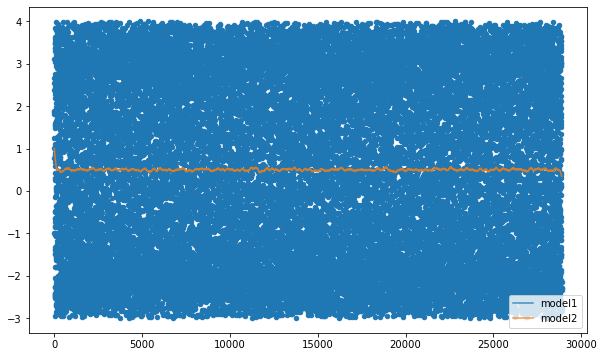

In [16]:
import numpy as np
import time
from sklearn.neighbors import NearestNeighbors
from sklearn.base import BaseEstimator, RegressorMixin

from sklearn.preprocessing import PolynomialFeatures

np.random.seed(42)


from pyLOESS import LOESSGernealization, LOESSTimeseries




import matplotlib.pyplot as plt


x = np.arange(0, 28888, 1)
x = x + np.random.random(x.size)
y = 3 * np.sin(x/10) + np.random.random(x.size)
y[10] = -1
y[12] = -1



k = 288
degree = 1
robust = True

t = time.perf_counter()
model1 = LOESSGernealization(k=k, robust=robust, degree=degree)
model1.fit(x.reshape(-1, 1), y)
pred1 = model1.predict(x.reshape(-1, 1))
print(time.perf_counter()-t)

t = time.perf_counter()
model2 = LOESSTimeseries(k=k, robust=robust, degree=degree)
model2.fit(x, y)
pred2 = model2.predict(x)
print(time.perf_counter()-t)

fig = plt.figure(figsize=(10, 6))
plt.scatter(x, y, s=20)
plt.plot(x, pred1, alpha=0.8, label='model1')
plt.plot(x, pred2, alpha=0.8, label='model2')
plt.legend()